In [1]:
import os
import cv2
import json
import shutil
import pickle
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt

from skimage import draw
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture as GMM

In [23]:
def load(dir_path):
    images_dir = os.path.join(dir_path, "images")
    bodies_dir = os.path.join(dir_path, "labels")
    
    filenames, images, bodies = [], [], []

    for file in os.listdir(images_dir):
        filenames.append(file)
        images.append(cv2.imread(os.path.join(images_dir, file)))

    for file in os.listdir(bodies_dir):
        body = cv2.imread(os.path.join(bodies_dir, file))
        body = cv2.cvtColor(body, cv2.COLOR_RGB2GRAY)
        body = body.astype("uint8")
        bodies.append(body)

    print(f"loading successful! {len(images)} images, {len(bodies)} bodies, {len(filenames)} filenames")
    return images, bodies, filenames

data_dir = "..\data"
dir_path = os.path.join(data_dir, "joint-ep-of-thu-ego-heiko", "train")
images, bodies, filenames = load(dir_path)

print(f"image {images[0].shape}")
print(f"body {bodies[0].shape} {np.unique(bodies[0])}")

loading successful! 8005 images, 8005 bodies, 8005 filenames
image (480, 640, 3)
body (480, 640) [0 1]


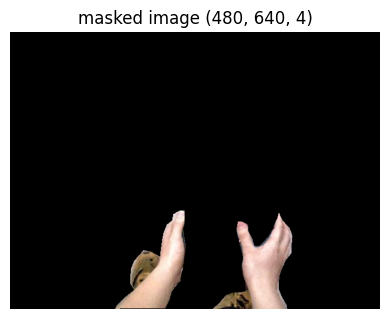

In [5]:
def get_masked_image(img_id, images, bodies, alpha=False):
    image = images[img_id].copy()
    body = bodies[img_id].copy()
    body_rgb = cv2.cvtColor(body, cv2.COLOR_GRAY2RGB)
    # apply mask
    image = image*body_rgb
#     image = cv2.bitwise_and(img, img, mask=body)
    if alpha:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
        image[:, :, 3] = body
    return image

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies, alpha=True)

# display
display_img(img, title=f"masked image {img.shape}")

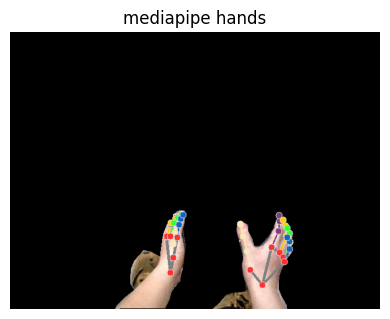

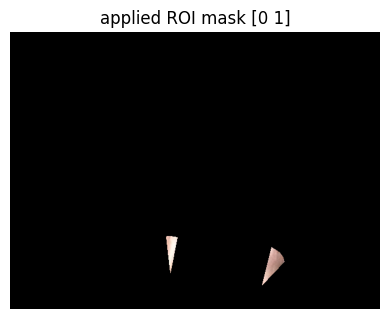

In [6]:
def get_ROI_mask(img, hands=2, draw=False):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands
    landmarks_dict = {
        "wrist": mp_hands.HandLandmark.WRIST,
        "index": mp_hands.HandLandmark.INDEX_FINGER_MCP,
        "middle": mp_hands.HandLandmark.MIDDLE_FINGER_MCP,
        "ring": mp_hands.HandLandmark.RING_FINGER_MCP,
        "pinky": mp_hands.HandLandmark.PINKY_MCP,
    }

    # get ROIs
    ROIs = []
    with mp_hands.Hands(static_image_mode=True, max_num_hands=hands, min_detection_confidence=0.5) as hands:
        results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            img_height, img_width, _ = img.shape
            if draw:
                annotated_img = img.copy()
            for hand_landmarks in results.multi_hand_landmarks:
                if draw:
                    mp_drawing.draw_landmarks(annotated_img, hand_landmarks, mp_hands.HAND_CONNECTIONS, mp_drawing_styles.get_default_hand_landmarks_style(), mp_drawing_styles.get_default_hand_connections_style())
                coords = []
                for k, v in landmarks_dict.items():
                    coords.append([int(hand_landmarks.landmark[v].x*img_width), int(hand_landmarks.landmark[v].y*img_height)])
                ROIs.append(coords)
            if draw:
                display_img(annotated_img, title="mediapipe hands")
    
    # create ROI mask
    mask = np.zeros(shape=img.shape[:2], dtype=np.uint8)
    for ROI in ROIs:
        cv2.fillPoly(mask, pts=[np.array(ROI)], color=1)
    
    return mask

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# get ROI mask
ROI_mask = get_ROI_mask(img, hands=2, draw=True)
display_img(cv2.bitwise_and(img, img, mask=ROI_mask), title=f"applied ROI mask {np.unique(ROI_mask)}")

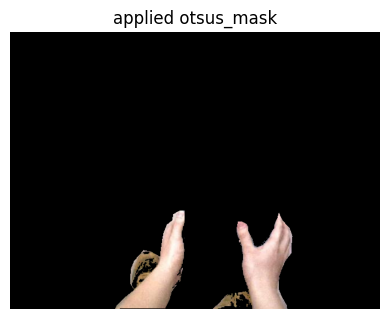

In [8]:
def get_otsus_mask(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # apply otsu's thresholding
    threshold, otsus_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    otsus_mask = otsus_mask.astype(bool).astype("uint8")
    
    return otsus_mask

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# apply otsus mask
otsus_mask = get_otsus_mask(img)
display_img(img*otsus_mask[:,:,np.newaxis], title="applied otsus_mask")

In [9]:
import argparse
import time
from glob import glob
from scipy import signal


# This function detects the hands within the image using Mediapipe library
# Needs image in RGB and the DL inferred label as input
# Outputs:
# hands_rgb = an image only containing the hands in RGB
# final_mask = mask of the hands
def hands_det(img_rgb, infer_label):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands
    image_height, image_width, _ = img_rgb.shape
    infer_mask = np.uint8(infer_label)
    with mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=4,
            min_detection_confidence=0.5) as hands:

        # image.flags.writeable = False
        results = hands.process(img_rgb)
        annotated_image = img_rgb.copy()
        hands_rg = np.zeros_like(img_rgb)
        hands_mask = np.zeros_like(img_rgb[:, :, 0])

        if results.multi_hand_landmarks:
            landmarks = {}
            for hand_landmarks in results.multi_hand_landmarks:
                # Here is How to Get All the Coordinates
                for ids, landmrk in enumerate(hand_landmarks.landmark):

                    cx, cy = int(landmrk.x * image_width), int(landmrk.y * image_height)
                    #print(ids, cx, cy)
                    landmarks[ids] = (cx, cy)
                    if ids == 0:
                        cv2.circle(hands_rg, (cx, cy), radius=20, color=(255, 0, 0), thickness=-1)

                    elif ids==4 or ids == 20 or ids == 8 or ids == 16 or ids == 12 or ids == 7 or ids==11 or ids==3 or ids==15 or ids==19:
                        cv2.circle(hands_rg, (cx, cy), radius=2, color=(255, 0, 0), thickness=-1)
                    else:
                        cv2.circle(hands_rg, (cx, cy), radius=5, color=(255, 0, 0), thickness=-1)

                # Draw lines in the palms
                cv2.line(hands_rg, (landmarks[0]), (landmarks[1]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[5]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[9]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[13]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[0]), (landmarks[17]), color=(0, 255, 0), thickness=6)

                # Draw lines between knuckles
                cv2.line(hands_rg, (landmarks[5]), (landmarks[9]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[9]), (landmarks[13]), color=(0, 255, 0), thickness=6)
                cv2.line(hands_rg, (landmarks[13]), (landmarks[17]), color=(0, 255, 0), thickness=6)

                cnt1= np.array([[landmarks[0], landmarks[17], landmarks[13]]])
                cnt2 = np.array([landmarks[0], landmarks[9], landmarks[13]])
                cnt3 = np.array([landmarks[0], landmarks[5], landmarks[9]])
                cnt4 = np.array([landmarks[0], landmarks[5], landmarks[1]])
                cnt5 = np.array([landmarks[2], landmarks[5], landmarks[1]])
                cv2.drawContours(hands_rg, [cnt1], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt2], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt3], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt4], 0, (0, 255, 0), -1)
                cv2.drawContours(hands_rg, [cnt5], 0, (0, 255, 0), -1)

                # Draw lines in the fingers
                #for i in range(1, 4):
                for i in range(1, 3):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(5, 8):
                for i in range(5, 7):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(9, 12):
                for i in range(9, 11):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(13, 16):
                for i in range(13, 15):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)
                #for i in range(17, 20):
                for i in range(17, 19):
                    cv2.line(hands_rg, (landmarks[i]), (landmarks[i + 1]), color=(0, 255, 0), thickness=3)

            hands_mask = np.uint8(np.where((hands_rg[:, :, 0] == 255) | (hands_rg[:, :, 1] == 255), 1, 0))
            final_mask = np.uint8(infer_mask[:,:] & hands_mask)
            #final_mask = hands_mask
            hands_rgb = np.zeros_like(img_rgb)
            hands_rgb[:, :, 0] = np.where(final_mask == 1, img_rgb[:, :, 0], 0)
            hands_rgb[:, :, 1] = np.where(final_mask == 1, img_rgb[:, :, 1], 0)
            hands_rgb[:, :, 2] = np.where(final_mask == 1, img_rgb[:, :, 2], 0)
            return hands_rgb, final_mask, 1

        if not results.multi_hand_landmarks:
            return np.zeros_like(img_rgb), np.zeros_like(img_rgb[:, :, 0]), 0


# This function obtains the color thresholds of the detected hands in the desired color space
# This is performed by setting intervals centered at the most relevant peaks of the histograms of 3 color channels
# returns 3 lists containing the 3 sets of thresholds (one per color component)
def get_color_thres_new(hands_rgb, mask_hands, color_space):
    # Parameters  needed:
    # hands_rgb: it is the part of the image which contains the hands only. It is needed to analyse its histograms and find its peaks
    # mask_hands: necesarry for the function cv2.calcHist. Thanks to applying this masks, only the pixels within this mask will be analysed
    # color_space: to select the color space in which the segmentation is going to be carried out
    if color_space == "hsv":
        hands = cv2.cvtColor(hands_rgb, cv2.COLOR_RGB2HSV)
    elif (color_space == "lab"):
        hands = cv2.cvtColor(hands_rgb, cv2.COLOR_RGB2Lab)
    elif (color_space == "ycrcb"):
        hands = cv2.cvtColor(hands_rgb, cv2.COLOR_RGB2YCrCb)
    elif (color_space == "hcrb"):
        hands = cv2.cvtColor(hands_rgb, cv2.COLOR_RGB2HSV)
        handscrcb = cv2.cvtColor(hands_rgb, cv2.COLOR_RGB2YCrCb)
        # hands[:, :, 0] = handsh[:, :, 0]
        hands[:, :, 1] = handscrcb[:, :, 1]
        hands[:, :, 2] = handscrcb[:, :, 2]

    # Obtaining histograms for each component of the color_space and their peaks for the hands ONLY (pixels within hand_mask area)
    # For Y componenet, the distance is taken into account because there are a lot of peaks in a continuous distribution along x axis
    # So, it is better to collect less peaks, but covering all the range with the purpose of not losing info
    # The "umbral" parameter is the distance from the peak to stablish the upper and lower limits. The value used later is 10
    # Therefore, with a value of distance=19, asssuming a continuous distribution, all values are covered
    firstF = cv2.calcHist([hands], [0], mask_hands, [256], [0, 256])
    peaksfirst = signal.find_peaks(np.concatenate(([min(firstF.flatten())], firstF.flatten(), [min(firstF.flatten())])),distance=10, height=100)

    # For Cr and Cb, prominence is used, as the color is well concentrated in a small range of color
    secF = cv2.calcHist([hands], [1], mask_hands, [256], [0, 256])
    peakssec = signal.find_peaks(np.concatenate(([min(secF.flatten())], secF.flatten(), [min(secF.flatten())])), prominence=75)
    thirdF = cv2.calcHist([hands], [2], mask_hands, [256], [0, 256])
    peaksthird = signal.find_peaks(np.concatenate(([min(thirdF.flatten())], thirdF.flatten(), [min(thirdF.flatten())])), prominence=75)

    # Stablishing superior and inferior thresholds centered in each peak of each color component (with a total width of 2*umbral)
    thresholds1 = []
    umbral = 10
    for i in range(len(peaksfirst[0])):
        thresholds1.append([np.clip(peaksfirst[0][i] - 20, 0, 255), np.clip(peaksfirst[0][i] + 20, 0, 255)])

    thresholds2 = []
    for i in range(len(peakssec[0])):
        thresholds2.append([np.clip(peakssec[0][i] - umbral, 0, 255), np.clip(peakssec[0][i] + umbral, 0, 255)])

    thresholds3 = []
    for i in range(len(peaksthird[0])):
        thresholds3.append([np.clip(peaksthird[0][i] - umbral, 0, 255), np.clip(peaksthird[0][i] + umbral, 0, 255)])

    return thresholds1, thresholds2, thresholds3


# This function segments by color the image by using the found thresholds
# Returns a mask which contains the pixels whose color information lies within all thresholds
def segment_skin_by_thresh(image_rgb, thresholds1, thresholds2, thresholds3, color_space):
    if color_space == "hsv":
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    if (color_space == "lab"):
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)

    elif (color_space == "ycrcb"):
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)

    elif (color_space == "hcrb"):
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
        imagecrcb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)
#         image[:, :, 0] = imageh[:, :, 0]
        image[:, :, 1] = imagecrcb[:, :, 1]
        image[:, :, 2] = imagecrcb[:, :, 2]

    # We take the pixels whose color is within any of the thresholds of the set of the first color component (e.g Hue)
    mask1 = np.zeros_like(image[:, :, 0], dtype='uint8')
    for i in range(len(thresholds1)):
        maski = np.where((image[:, :, 0] <= thresholds1[i][1]) & (image[:, :, 0] >= thresholds1[i][0]), 1, 0)
        mask1 = maski | mask1

    # We take the pixels whose color is within any of the thresholds of the set of the second color component (e.g Saturation)
    mask2 = np.zeros_like(image[:, :, 1], dtype='uint8')
    for i in range(len(thresholds2)):
        maski = np.where((image[:, :, 1] <= thresholds2[i][1]) & (image[:, :, 1] >= thresholds2[i][0]), 1, 0)
        mask2 = maski | mask2

    # We take the pixels whose color is within any of the thresholds of the set of the thrid color component (e.g Value)
    mask3 = np.zeros_like(image[:, :, 2], dtype='uint8')
    for i in range(len(thresholds3)):
        maski = np.where((image[:, :, 2] <= thresholds3[i][1]) & (image[:, :, 2] >= thresholds3[i][0]), 1, 0)
        mask3 = maski | mask3

    # Return the intersection of the three masks (pixels whose color is within the thresholds of the all three masks)
    return mask1 & mask2 & mask3

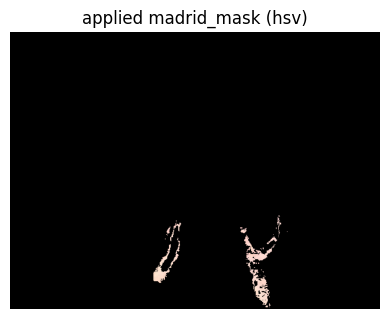

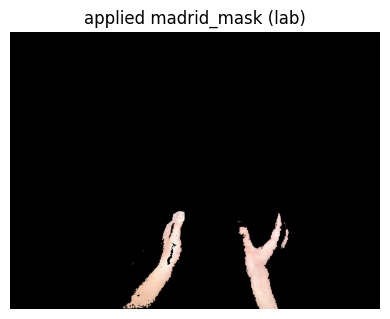

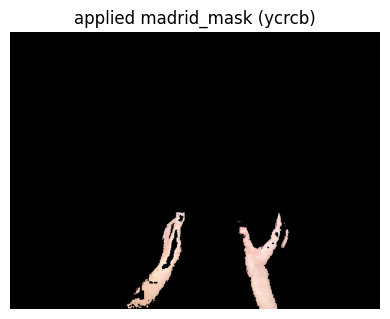

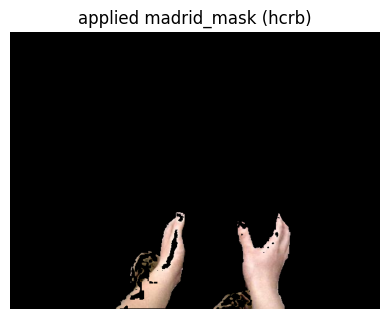

In [11]:
def get_madrid_mask(img, infer_label, color_space):   
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # This function detects the hands within the image using Mediapipe library
    # Needs image in RGB and the DL inferred label as input
    # Outputs:
    # hands_rgb = an image only containing the hands in RGB
    # final_mask = mask of the hands
    hands_rgb, mask_hands, success = hands_det(img_rgb, infer_label)

    # This function obtains the color thresholds of the detected hands in the desired color space
    # This is performed by setting intervals centered at the most relevant peaks of the histograms of 3 color channels
    # returns 3 lists containing the 3 sets of thresholds (one per color component)
    thresholds1, thresholds2, thresholds3 = get_color_thres_new(hands_rgb, mask_hands, color_space)

    # This function segments by color the image by using the found thresholds
    # Returns a mask which contains the pixels whose color information lies within all thresholds
    mask = segment_skin_by_thresh(img_rgb, thresholds1, thresholds2, thresholds3, color_space)
        
    return mask.astype("uint8")
    
# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)
# img = images[img_id].copy()

# get label
body = bodies[img_id].copy()

# apply madrid_mask
color_spaces = ["hsv", "lab", "ycrcb", "hcrb"]
results = []
for color_space in color_spaces:
    madrid_mask = get_madrid_mask(img, body, color_space)
    display_img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)*madrid_mask[:,:,np.newaxis], convert=False, title=f"applied madrid_mask ({color_space})")

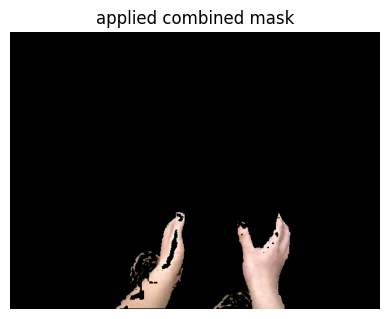

In [12]:
def get_combined_mask(img, ROI_mask, body):
    # get masks
    masks = []
    masks.append(get_otsus_mask(img))
    masks.append(get_madrid_mask(img, body, "hcrb"))
        
    # merge masks
    combined_mask = masks[0]
    for mask in masks[1:]:
        combined_mask = cv2.bitwise_and(combined_mask, mask)
    return combined_mask

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# get label
body = bodies[img_id].copy()

# get ROI mask
ROI_mask = get_ROI_mask(img)

# apply combined mask
combined_mask = get_combined_mask(img, ROI_mask, body)
display_img(img.copy()*combined_mask[:,:,np.newaxis], title="applied combined mask")

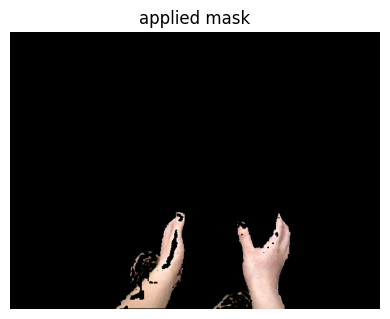

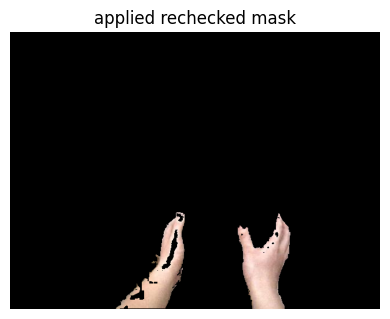

In [13]:
def recheck_mask_with_ROIs(img, mask, ROI_mask, body):
    # get connected components
    n, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    
    # match with ROIs
    matches = np.unique(labels[ROI_mask == 1].flatten())

    # combine masks
    mask = None
    for i in set(matches):
        # skip background
        if i == 0:
            continue
        # merge mask for matching components
        if mask is None:
            mask = np.where(labels==i, 1, 0).astype("uint8")
        else:
            mask = cv2.bitwise_or(mask, np.where(labels==i, 1, 0).astype("uint8"))
            mask = cv2.bitwise_and(mask, body)
    
    # recheck with label
    if mask is not None:
        mask = cv2.bitwise_and(mask, body)
    return mask

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# get label
body = bodies[img_id].copy()

# get ROI mask
ROI_mask = get_ROI_mask(img)
# display_img(ROI_mask, title="ROI mask")

# get mask
mask = get_combined_mask(img, ROI_mask, body)
# display_img(mask, convert=False, title="mask")

# apply mask
display_img(img.copy()*mask[:,:,np.newaxis], title="applied mask")

# recheck
mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)
# display_img(mask, convert=False, title="rechecked mask")

# apply mask
display_img(img.copy()*mask[:,:,np.newaxis], title="applied rechecked mask")

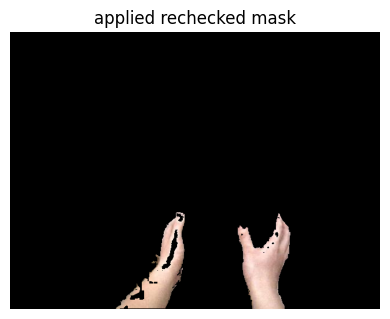

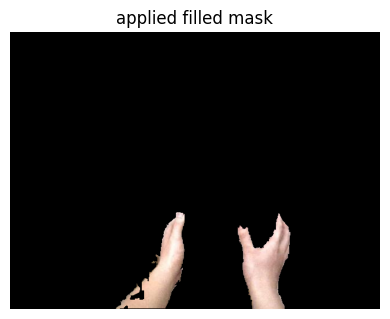

In [15]:
def fill_mask_holes(mask):
    if mask is not None:
        h, w = mask.shape
        canvas = np.zeros((h+2, w+2), np.uint8)
        canvas[1:h+1, 1:w+1] = mask.copy()

        mask_tmp = np.zeros((h+4, w+4), np.uint8)

        cv2.floodFill(canvas, mask_tmp, (0, 0), 1)
        canvas = canvas[1:h+1, 1:w+1].astype(bool)
        return (~canvas | mask.astype(np.uint8))
    else:
        return None

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# get label
body = bodies[img_id].copy()

# get ROI mask
ROI_mask = get_ROI_mask(img)

# get mask
mask = get_combined_mask(img, ROI_mask, body)

# recheck
mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)

# apply mask
display_img(img.copy()*mask[:,:,np.newaxis], title="applied rechecked mask")

# fill holes in mask
mask = fill_mask_holes(mask)

# apply mask
display_img(img.copy()*mask[:,:,np.newaxis], title="applied filled mask")

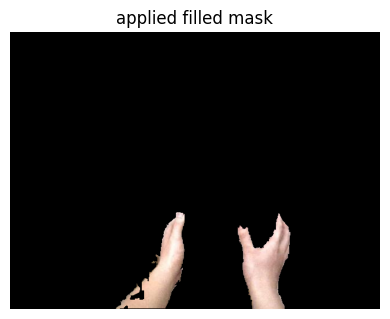

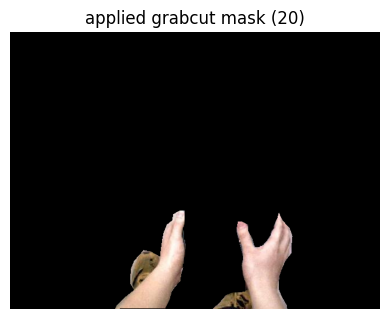

In [18]:
def get_grabcut_mask(img, mask, body, iter_count=1):
    if mask is not None:
        # convert mask
        grabcut_mask = np.where((mask==1), 1, 2).astype("uint8")
        grabcut_mask[body == 0] = 0

        # create placeholders
        bgdModel = np.zeros((1,65), np.float64)
        fgdModel = np.zeros((1,65), np.float64)

        # apply grabcut
        grabcut_mask, bgdModel, fgdModel = cv2.grabCut(
                img=img, mask=grabcut_mask, rect=None,
                bgdModel=bgdModel, fgdModel=fgdModel,
                iterCount=iter_count, mode=cv2.GC_INIT_WITH_MASK)
        # return mask
        grabcut_mask = np.where((grabcut_mask==2)|(grabcut_mask==0), 0, 1).astype("uint8")
        return grabcut_mask
    else:
        return None

# get img
img_id = 30
img = get_masked_image(img_id, images, bodies)

# get label
body = bodies[img_id].copy()

# get ROI mask
ROI_mask = get_ROI_mask(img)

# get mask
mask = get_combined_mask(img, ROI_mask, body)

# recheck
mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)

# fill holes in mask
mask = fill_mask_holes(mask)
# display_img(mask, convert=False, title="filled mask")
display_img(img.copy()*mask[:,:,np.newaxis], title="applied filled mask")

# apply grabcut mask
iter_count = 20
grabcut_mask = get_grabcut_mask(img, mask, body, iter_count)
# display_img(grabcut_mask, convert=False, title="grabcut mask")
display_img(img.copy()*grabcut_mask[:,:,np.newaxis], title=f"applied grabcut mask ({iter_count})")

In [19]:
def overlay_two_images(image, overlay, ignore_color=[0, 0, 0]):
    ignore_color = np.asarray(ignore_color)
    mask = (overlay==ignore_color).all(-1, keepdims=True)
    out = np.where(mask, image, (image * 0.5 + overlay * 0.5).astype(image.dtype))
    return out

In [39]:
# load dataset
data_dir = "..\data"
dir_path = os.path.join(data_dir, "joint-ep-of-thu-ego-heiko", "val")
images, bodies, filenames = load(dir_path)

# create target folders
preds_dir = os.path.join(dir_path, "preds")
overlays_dir = os.path.join(dir_path, "overlays")
os.makedirs(preds_dir, exist_ok=True)
os.makedirs(overlays_dir, exist_ok=True)

loading successful! 1069 images, 1069 bodies, 1069 filenames


In [40]:
# run
img_ids = range(len(images))
pbar = tqdm(img_ids)
error_filenames = set()
for img_id in pbar:
    # get img
    img = get_masked_image(img_id, images, bodies)

    # get body
    body = bodies[img_id].copy()
    
    # get filename
    filename = filenames[img_id]

    try:
        # get ROI mask
        ROI_mask = get_ROI_mask(img)
        assert 1 in np.unique(ROI_mask.flatten())

        # get mask
        mask = get_combined_mask(img, ROI_mask, body)

        # recheck ROIs
        mask = recheck_mask_with_ROIs(img, mask, ROI_mask, body)

        # fill holes
        mask = fill_mask_holes(mask)                

        # convert mask
        grabcut_mask = np.where((mask==1), 1, 2).astype("uint8")
        grabcut_mask[body == 0] = 0

    except Exception as e:
        error_filenames.add(filename)
        grabcut_mask = np.zeros(shape=body.shape).astype("uint8")

    # create placeholders
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)

    # apply grabcut
    try:
        grabcut_mask, bgdModel, fgdModel = cv2.grabCut(
                img=img, mask=grabcut_mask, rect=None,
                bgdModel=bgdModel, fgdModel=fgdModel,
                iterCount=20, mode=cv2.GC_INIT_WITH_MASK)
        pred = np.where((grabcut_mask==2)|(grabcut_mask==0), 0, 1).astype("uint8")
    except Exception as e:
        error_filenames.add(filename)
        pred = np.zeros(shape=body.shape).astype("uint8")
    finally:
        # create overlay
        img = cv2.cvtColor(images[img_id], cv2.COLOR_BGR2RGB).astype("uint8")
        mask = cv2.merge([pred*0, pred*255, pred*0]).astype("uint8")
        overlay = overlay_two_images(img, mask)

        # save
        cv2.imwrite(os.path.join(preds_dir, filename.replace(".jpg", ".png")), pred*255)
        cv2.imwrite(os.path.join(overlays_dir, filename.replace(".png", ".jpg")), cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB).astype("uint8"))

error_log_path = os.path.join(dir_path, "error_log.txt")
with open(error_log_path, "w") as outfile:
    outfile.write(str(error_filenames))

  0%|          | 0/1069 [00:00<?, ?it/s]